In [1]:
class MessageContent:
    def __init__(self, path_list: list[int], val: int):
        self.__path_list = path_list.copy()
        self.__val = val

    def get_path_list(self) -> list[int]:
        return self.__path_list.copy()

    def get_val(self) -> int:
        return self.__val

    def get_content(self) -> tuple[list[int], int]:
        return self.__path_list.copy(), self.__val

    def __str__(self):
        path = ''.join(str(p) for p in self.__path_list)
        return f'path: {path}, val: {self.__val}'

    def __repr__(self):
        return self.__str__()


class Message:
    def __init__(self, content_list: list[MessageContent], sender:int):
        self.__contents = content_list.copy()
        self.__sender = sender

    def get_content(self) -> list[MessageContent]:
        return self.__contents.copy()
    
    def get_sender(self) -> int:
        return self.__sender

    def __str__(self):
        contents_str = [str(content) for content in self.__contents]
        return f'sender: {self.get_sender()}\n' + '\n'.join(contents_str)

    def __repr__(self):
        return self.__str__()


In [2]:
from typing import Self
import networkx as nx
import matplotlib.pyplot as plt
from external.plot_tree import hierarchy_pos
import os
import sys


class Node:
    def __init__(self, parent: Self, proc_uid: int, val: int, path: list[int]):
        self.__proc_uid = proc_uid
        self.__parent = parent
        self.__children = []
        self.__val = val
        self.__path = path.copy()
        self.__depth = len(path)

    def get_proc_uid(self) -> int:
        return self.__proc_uid

    def get_parent(self) -> Self:
        return self.__parent

    def get_children(self) -> list[Self]:
        return self.__children

    def get_val(self) -> int:
        return self.__val
    
    def set_val(self, val: int):
        self.__val = val

    def get_path(self) -> list[int]:
        return self.__path.copy()

    def get_depth(self) -> int:
        return self.__depth

    def is_leaf(self) -> bool:
        return len(self.__children) == 0

    def is_root(self) -> bool:
        return self.__parent is None

    def add_child(self, child: Self):
        self.__children.append(child)

    def __str__(self):
        correct_path = [str(p) for p in self.get_path()[1:]]
        path = ''.join(correct_path)
        if self.is_leaf():
            return f'path: {path}, val: {self.__val}'
        else:
            return f'path: {path}'

    def __repr__(self):
        return self.__str__()


def save_plot(path):
    generate_file(path)
    plt.savefig(path)


def generate_file(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)

class EIGByzTree:
    def __init__(self, proc_uid: int, proc_count: int, proc_val: int):
        self.__proc_uid = proc_uid
        self.__proc_count = proc_count
        self.__root = Node(parent=None, proc_uid=-1, val=proc_val, path=[])

    def get_proc_uid(self) -> int:
        return self.__proc_uid

    def get_proc_count(self) -> int:
        return self.__proc_count

    def add_level(self):
        if self.__root.is_leaf():
            for i in range(1, self.__proc_count + 1):
                child = Node(parent=self.__root, proc_uid=i, val=None, path=[-1, i])
                self.__root.add_child(child)
        else:
            for child in self.__root.get_children():
                self.__add_level_non_root(node=child)

    def __add_level_non_root(self, node):
        if node.is_leaf():
            for i in range(1, self.__proc_count + 1):
                if i not in node.get_path():
                    new_path = node.get_path() + [i]
                    child = Node(parent=node, proc_uid=i, val=None, path=new_path)
                    node.add_child(child)
        else:
            for child in node.get_children():
                self.__add_level_non_root(node=child)

    def log(self):
        res = ''
        res += f'root: {self.__root.get_proc_uid()}'
        queue = []
        if not self.__root.is_leaf():
            queue = [c for c in self.__root.get_children()]
        last_depth = 1
        while len(queue) > 0:
            node = queue.pop(0)
            if node.get_depth() != last_depth:
                last_depth += 1
                res += '\n'
            res += node.__str__() + ' '
            if not node.is_leaf():
                queue = queue + node.get_children()
        return res
    
    def __str__(self):
        return self.log()

    def __repr__(self):
        return self.__str__()
    
    def convert_to_networkx_graph(self) -> nx.Graph:
        graph = nx.Graph()
        graph.add_node('-1')
        queue = [self.__root]
        while len(queue) > 0:
            node = queue.pop(0)
            path = ''.join(str(p) for p in node.get_path()[1:])
            if not node.is_root():
                parent = path[:-1] if len(path) > 1 else '-1'
                graph.add_edge(parent, path)
            if not node.is_leaf():
                queue = queue + node.get_children()
        return graph
    
    def plot_tree(self, fig_size:tuple[int, int] = (75, 10), path:str=None, node_size:int=1200):
        graph = self.convert_to_networkx_graph()
        plt.figure(figsize=fig_size)
        if self.__root.is_leaf():
            pos = nx.spring_layout(graph)
        else:
            pos = hierarchy_pos(graph, '-1')
        node_size_list = [node_size] * graph.number_of_nodes()
        nx.draw(graph, pos=pos, with_labels=True, node_size=node_size_list)
        if path is not None:
            save_plot(path)
    
    def get_tree_height(self) -> int:
        height = 0
        node = self.__root
        while not node.is_leaf():
            node = node.get_children()[0]
            height += 1
        return height
    
    def get_message(self) -> Message:
        if self.__root.is_leaf():
            msg_content = MessageContent(self.__root.get_path(), self.__root.get_val())
            return Message([msg_content], sender = self.get_proc_uid())
        else:
            msg_contents = self.__get_messages(self.__root)
            return Message(msg_contents, sender = self.get_proc_uid())
        
    def __get_messages(self, node: Node) -> list[MessageContent]:
        if node.is_leaf():
            return [MessageContent(node.get_path(), node.get_val())]
        else:
            msg_contents = []
            for child in node.get_children():
                msg_contents += self.__get_messages(child)
            return msg_contents
        
    def apply_msg(self, msg: Message):
        for msg_content in msg.get_content():
            if len(msg_content.get_path_list()) == 0:
                self.__apply_msg_content(self.__root, [msg.get_sender()], msg_content.get_val())
            else:
                path_from_root = msg_content.get_path_list()[1:]
                self.__apply_msg_content(self.__root, path_from_root, msg_content.get_val())
                
    def __apply_msg_content(self, node: Node, path:list[int], val: int):
        if path is None or len(path) == 0:
            node.set_val(val)
        else:
            next_id = path[0]
            next_node = None
            for child in node.get_children():
                if child.get_proc_uid() == next_id:
                    next_node = child
                    break
            self.__apply_msg_content(next_node, path[1:], val)

In [3]:
class Process:
    def __init__(self, proc_uid: int, proc_count: int, proc_val: int, is_byz:bool=False):
        self.__proc_uid = proc_uid
        self.__proc_count = proc_count
        self.__proc_val = proc_val
        self.__byz = is_byz
        self.__tree = EIGByzTree(self.__proc_uid, self.__proc_count, self.__proc_val)
        self.__received_messages = []
        
    def get_proc_uid(self) -> int:
        return self.__proc_uid
    
    def get_proc_count(self) -> int:
        return self.__proc_count
    
    def get_proc_val(self) -> int:
        return self.__proc_val
    
    def is_byz(self) -> bool:
        return self.__byz
    
    def receive_msg(self, msg:Message):
        self.__received_messages.append(msg)
        
    def apply_messages(self):
        for msg in self.__received_messages:
            self.__tree.apply_msg(msg)
            
    def generate_msg(self):
        return self.__tree.get_message()
    
    def plot_tree(self, fig_size:tuple[int, int] = (75, 10), path:str=None, node_size:int=1200):
        path = path + f'proc-{self.get_proc_uid()}/step-{self.__tree.get_tree_height()}.png' if path is not None else None
        self.__tree.plot_tree(fig_size=fig_size, path=path, node_size=node_size)
        
    def add_tree_level(self):
        tree_height = self.__tree.get_tree_height()
        if tree_height != self.get_proc_count():
            self.__tree.add_level()
        else:
            raise Exception(f'tree-has been completed with height: {tree_height}')

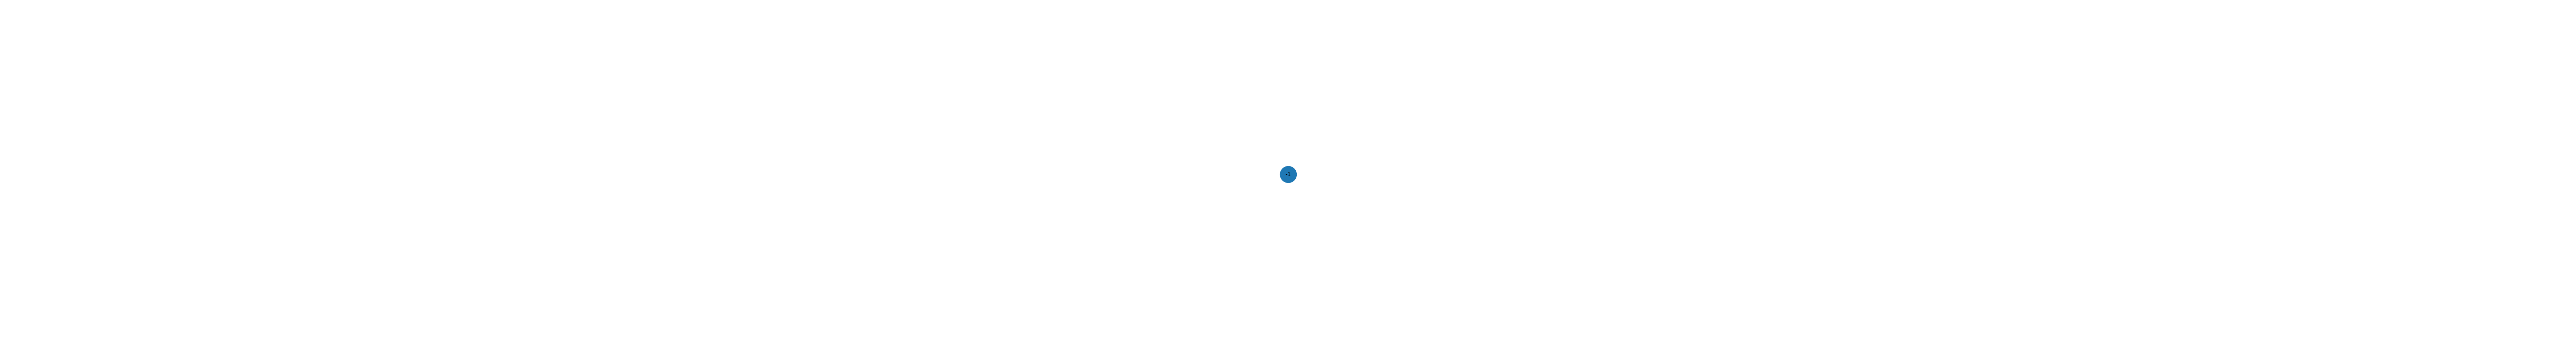

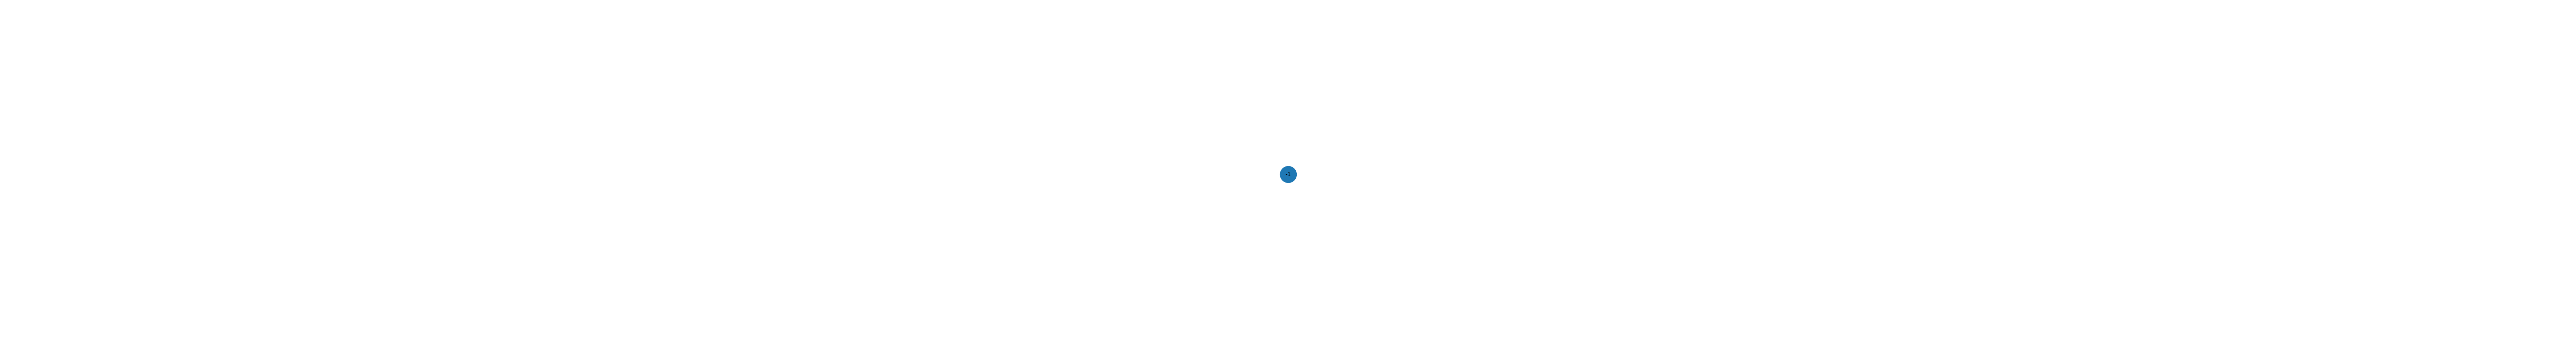

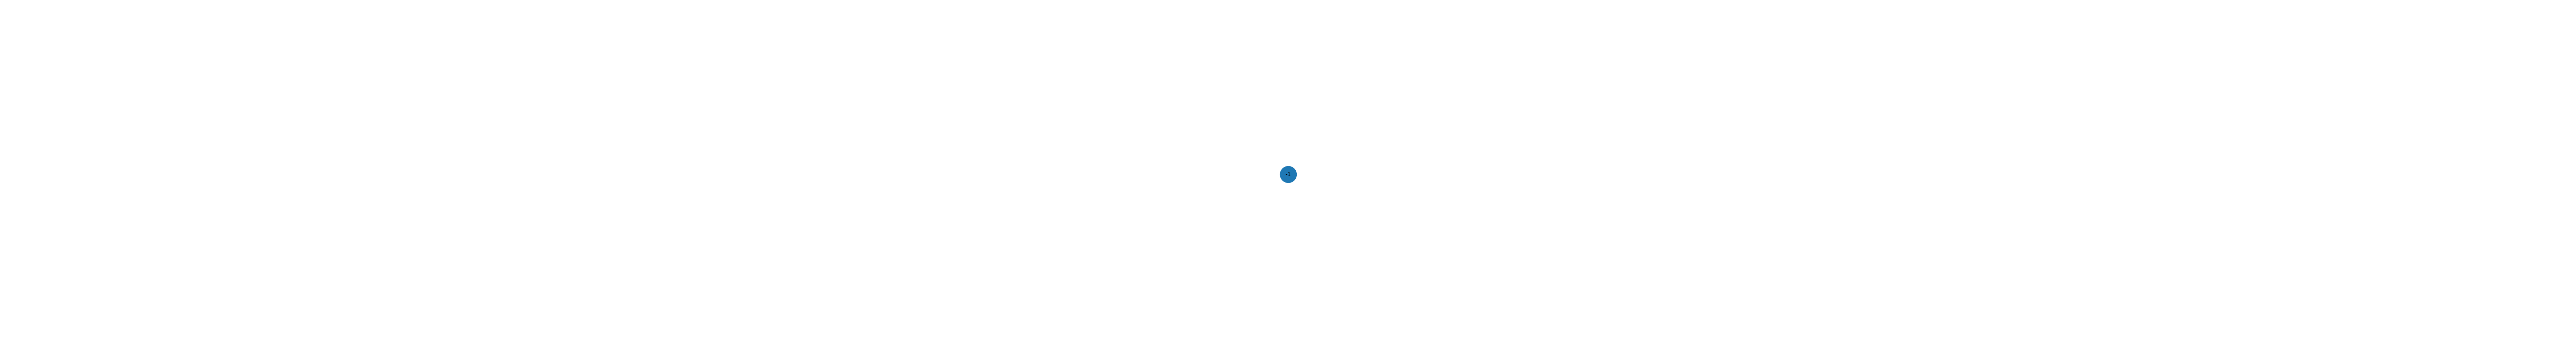

In [4]:
p1 = Process(1, 3, 1)
p2 = Process(2, 3, 1)
p3 = Process(3, 3, 1)
p1.plot_tree()
p2.plot_tree()
p3.plot_tree()

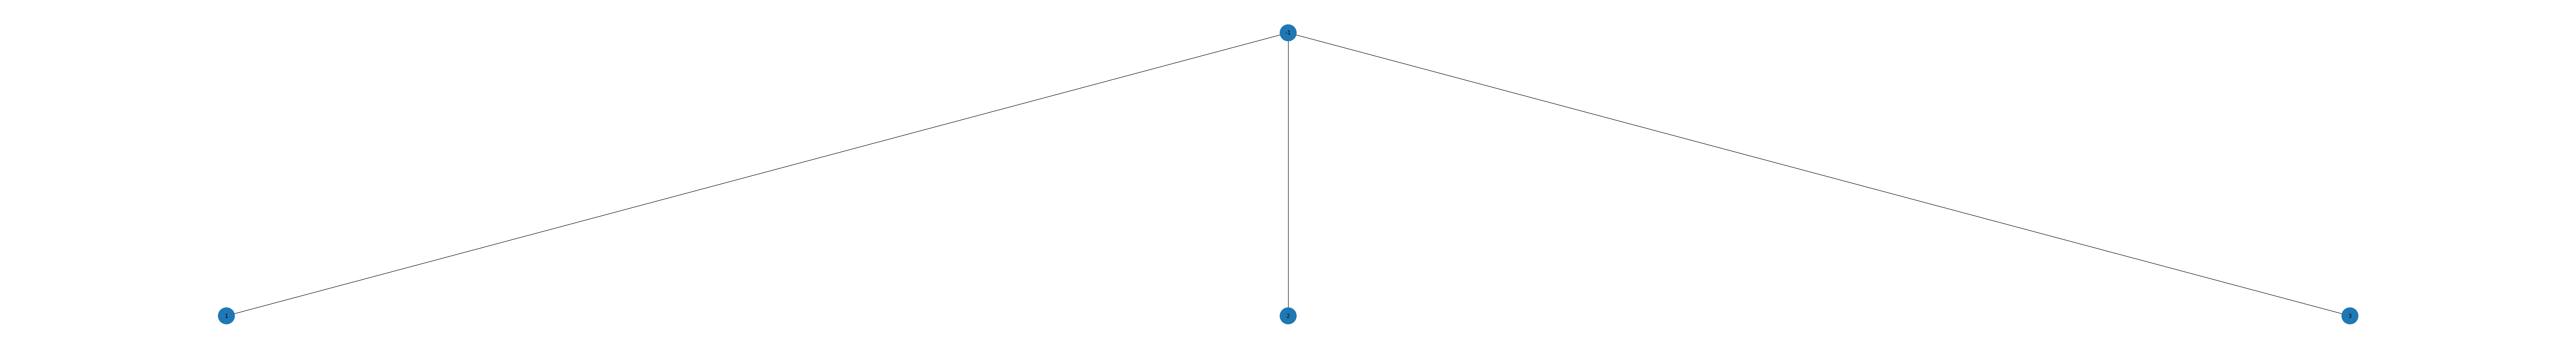

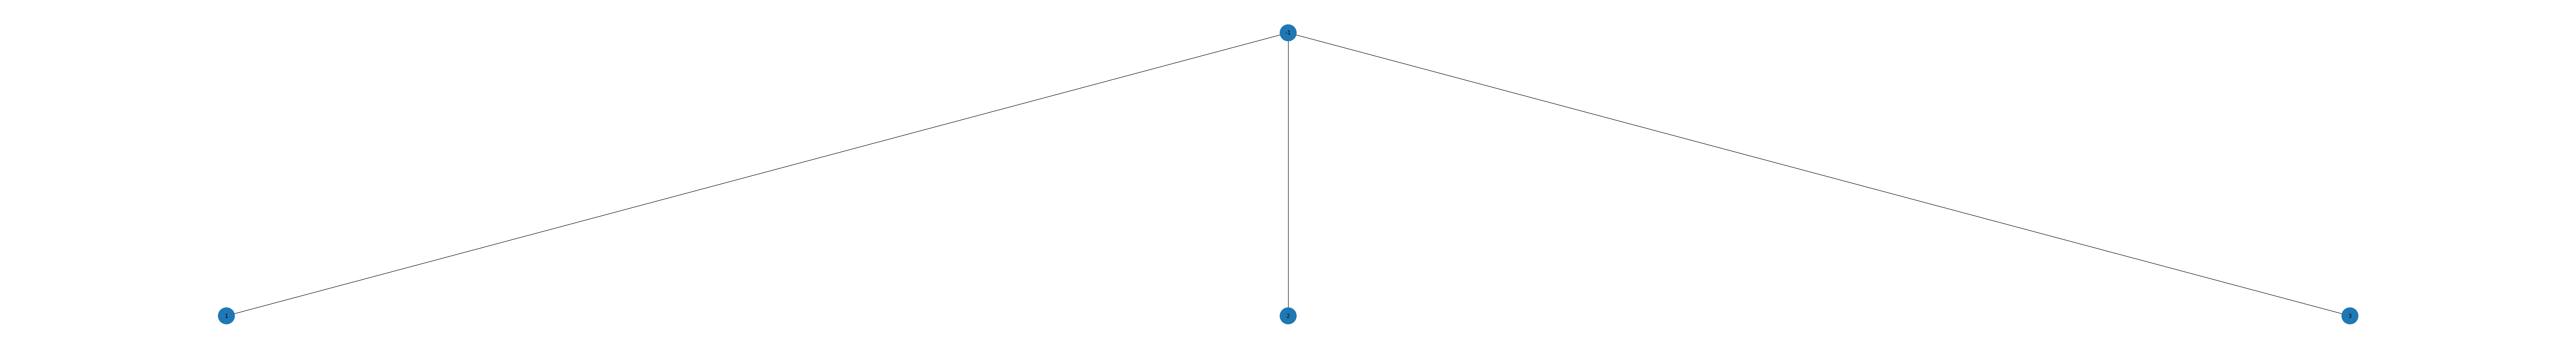

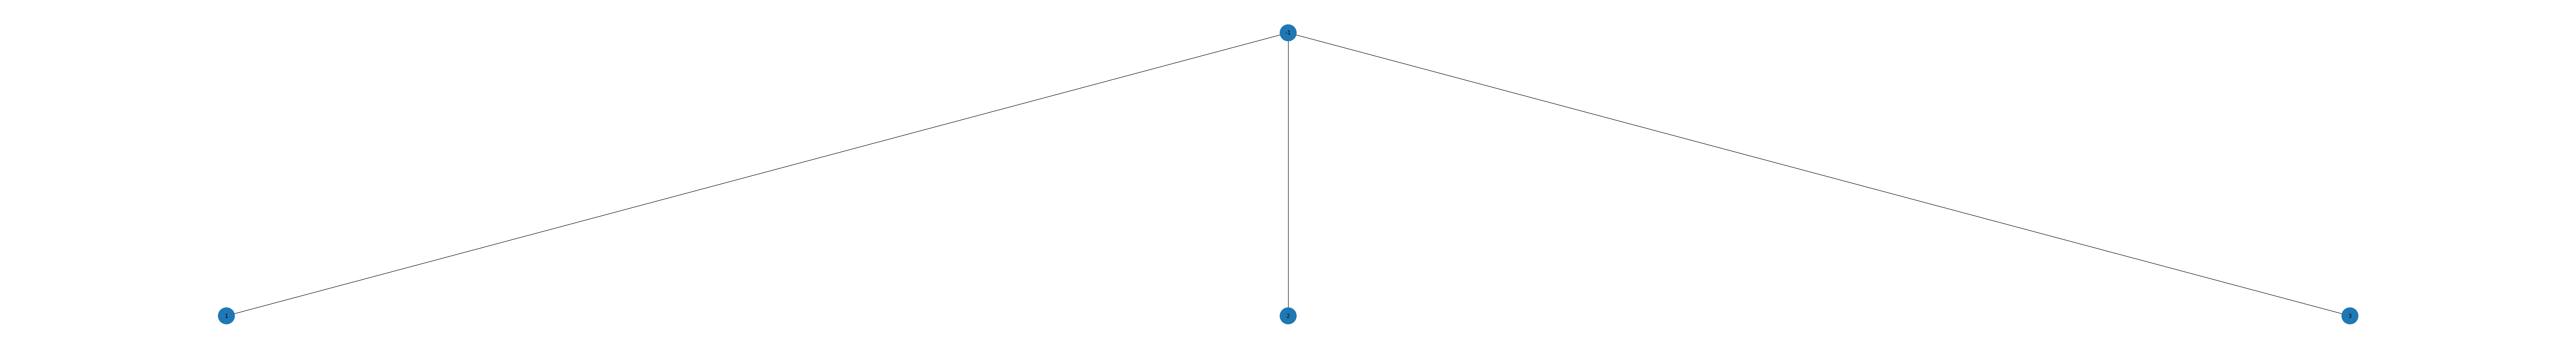

In [5]:
msg1 = p1.generate_msg()
msg2 = p2.generate_msg()
msg3 = p3.generate_msg()
p1.receive_msg(msg1)
p1.receive_msg(msg2)
p1.receive_msg(msg3)
p2.receive_msg(msg1)
p2.receive_msg(msg2)
p2.receive_msg(msg3)
p3.receive_msg(msg1)
p3.receive_msg(msg2)
p3.receive_msg(msg3)
p1.add_tree_level()
p2.add_tree_level()
p3.add_tree_level()
p1.apply_messages()
p2.apply_messages()
p3.apply_messages()
p1.plot_tree()
p2.plot_tree()
p3.plot_tree()

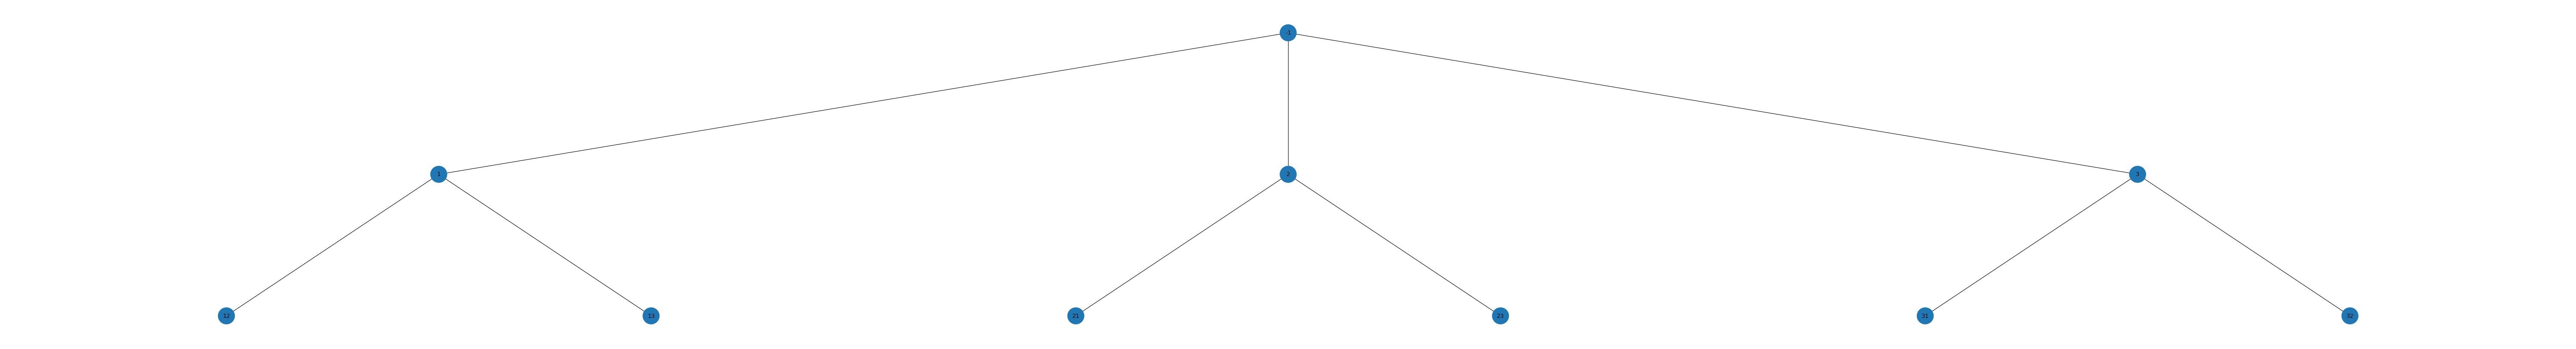

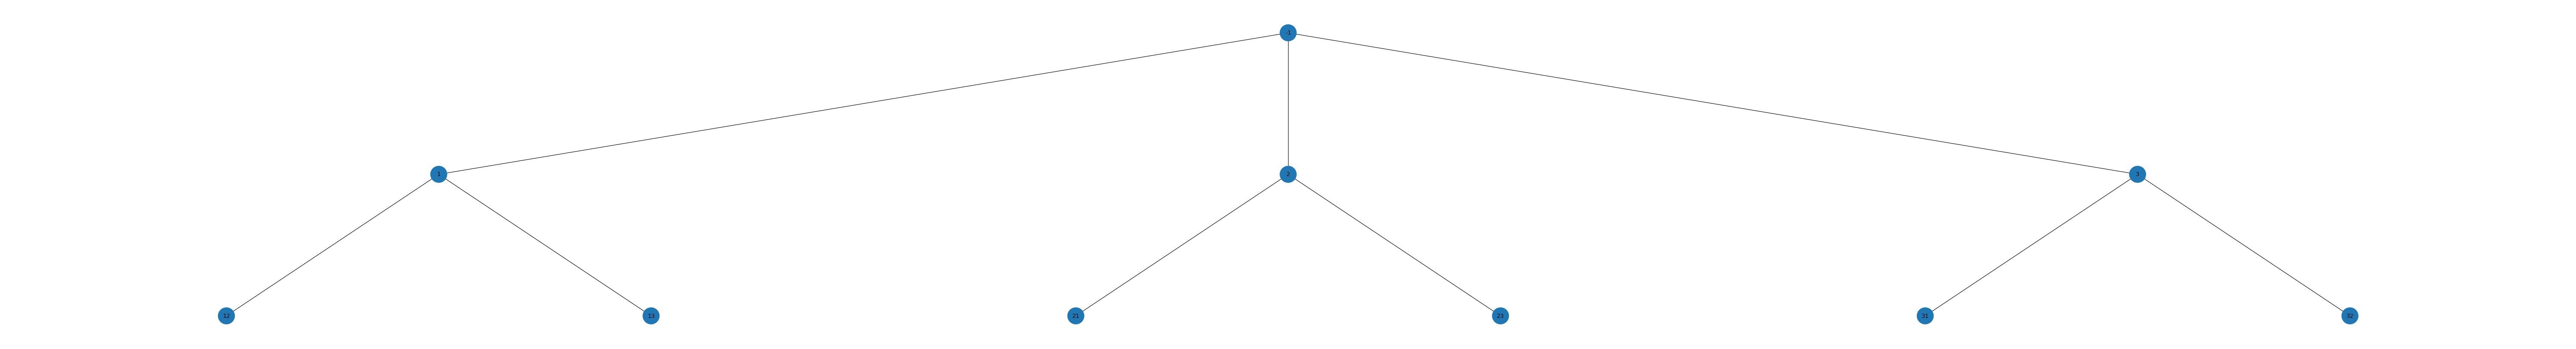

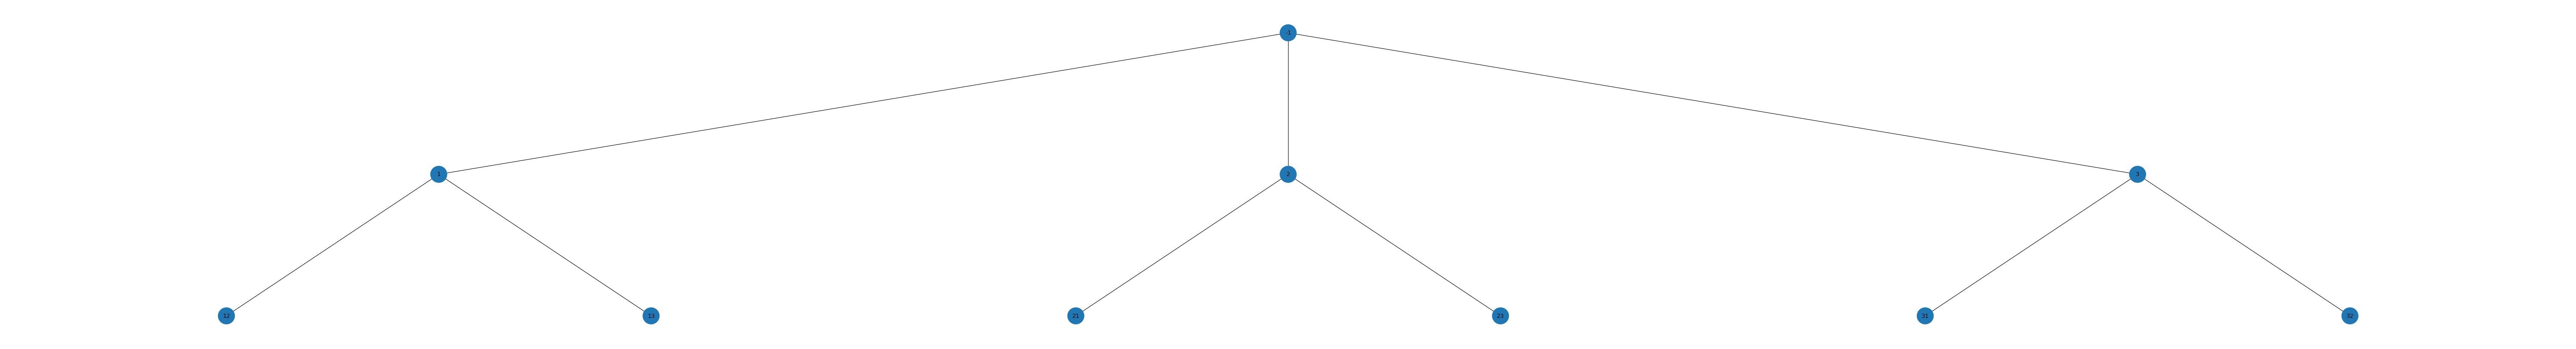

In [6]:
msg1 = p1.generate_msg()
msg2 = p2.generate_msg()
msg3 = p3.generate_msg()
p1.receive_msg(msg1)
p1.receive_msg(msg2)
p1.receive_msg(msg3)
p2.receive_msg(msg1)
p2.receive_msg(msg2)
p2.receive_msg(msg3)
p3.receive_msg(msg1)
p3.receive_msg(msg2)
p3.receive_msg(msg3)
p1.add_tree_level()
p2.add_tree_level()
p3.add_tree_level()
p1.apply_messages()
p2.apply_messages()
p3.apply_messages()
p1.plot_tree()
p2.plot_tree()
p3.plot_tree()

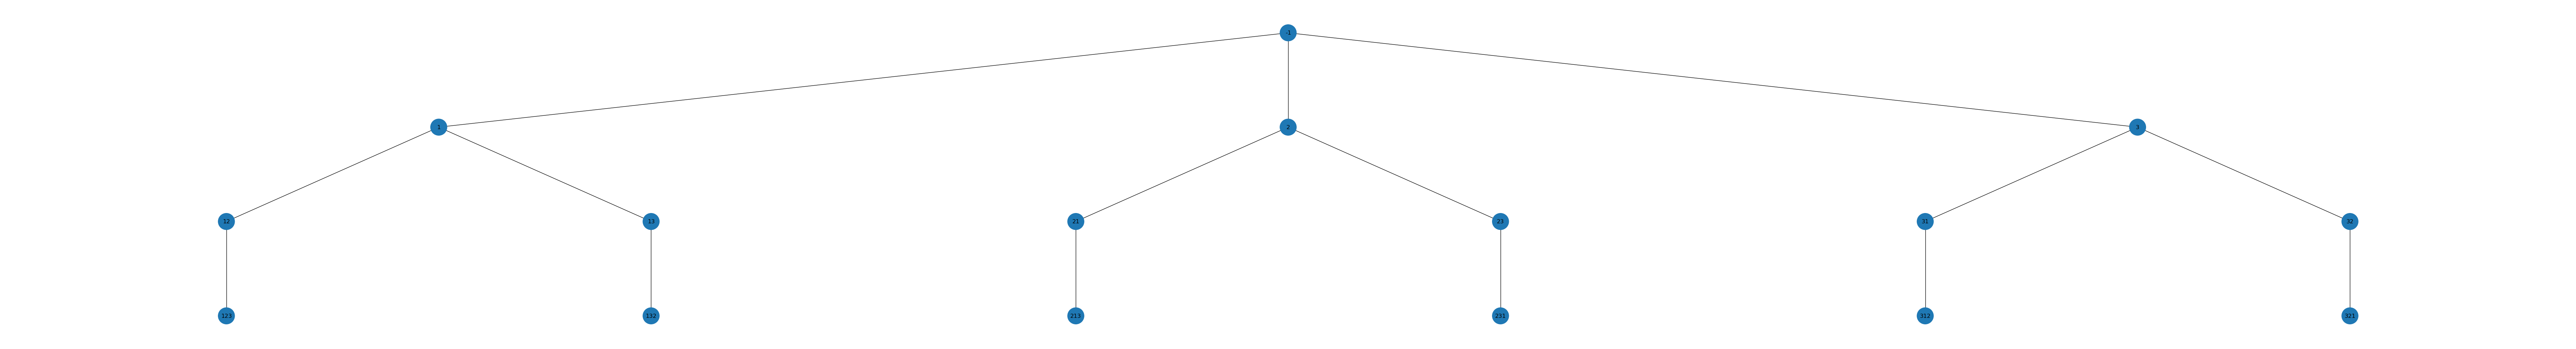

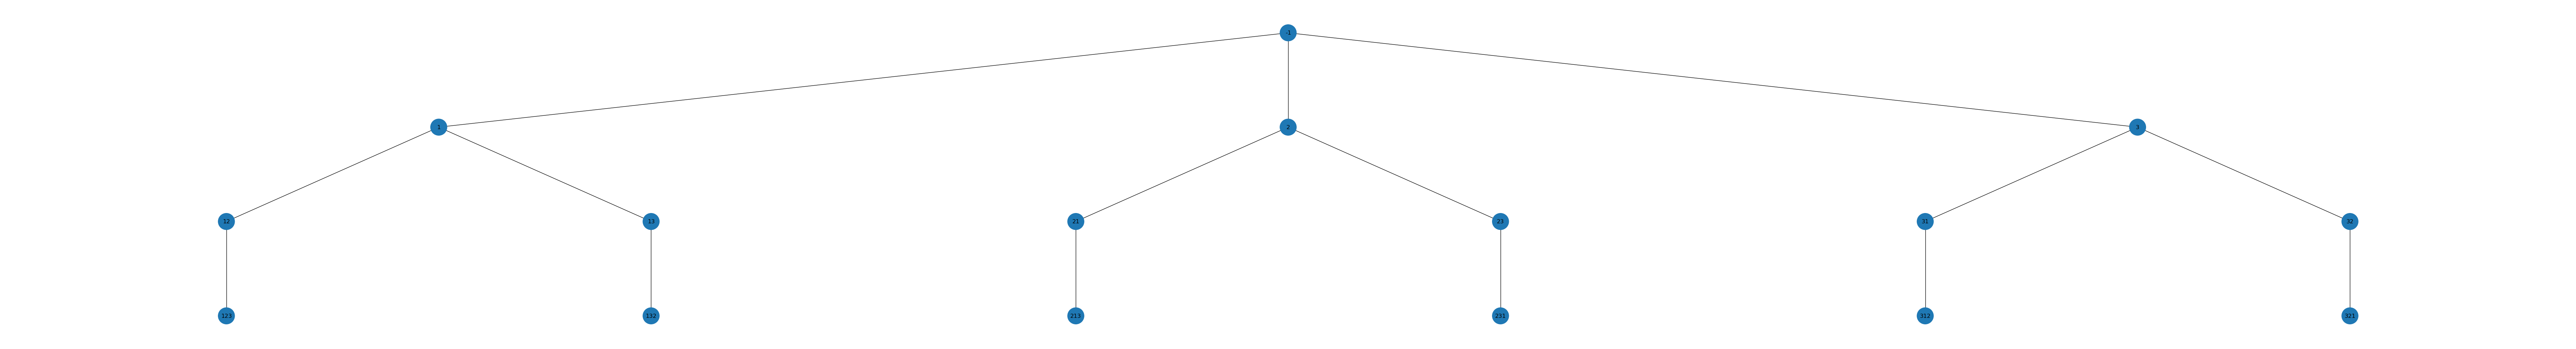

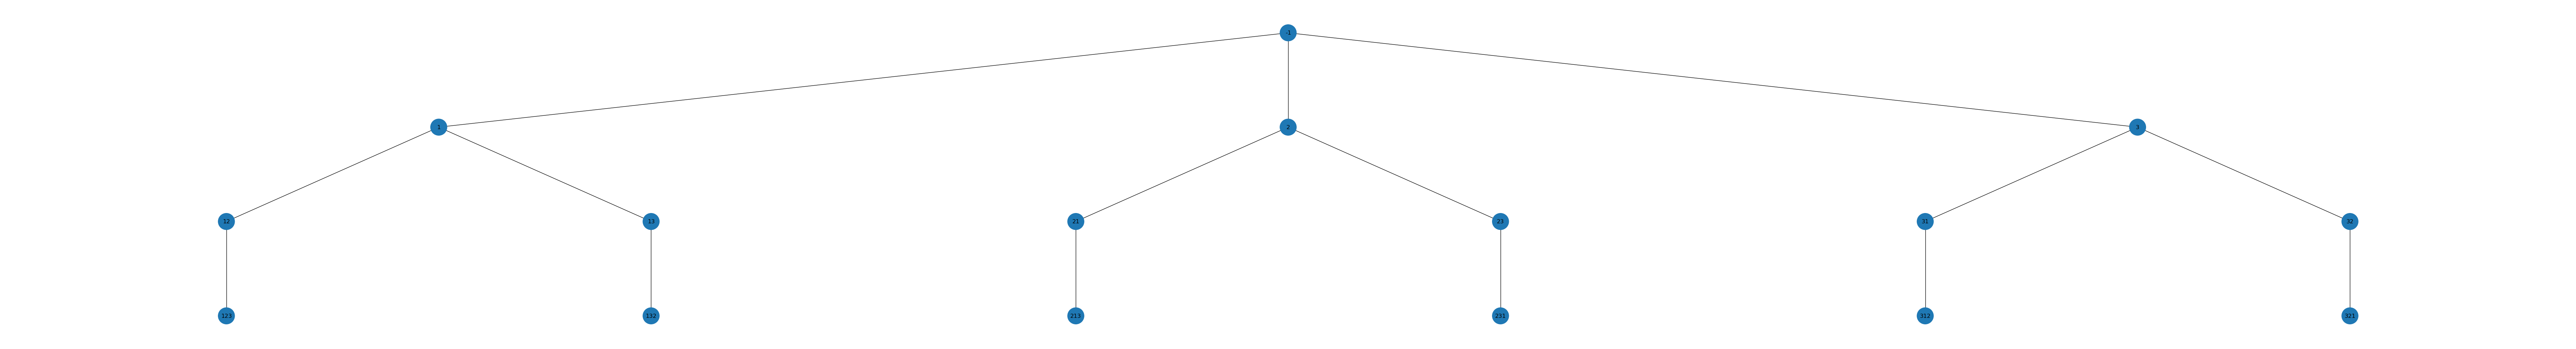

In [7]:
msg1 = p1.generate_msg()
msg2 = p2.generate_msg()
msg3 = p3.generate_msg()
p1.receive_msg(msg1)
p1.receive_msg(msg2)
p1.receive_msg(msg3)
p2.receive_msg(msg1)
p2.receive_msg(msg2)
p2.receive_msg(msg3)
p3.receive_msg(msg1)
p3.receive_msg(msg2)
p3.receive_msg(msg3)
p1.add_tree_level()
p2.add_tree_level()
p3.add_tree_level()
p1.apply_messages()
p2.apply_messages()
p3.apply_messages()
p1.plot_tree()
p2.plot_tree()
p3.plot_tree()